<a href="https://colab.research.google.com/github/LuisCarvalho314/CSCG/blob/main/CSCGcolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning cognitive maps as clone-structured graphs
Based on https://www.nature.com/articles/s41467-021-22559-5

Code at: http://github.com/vicariousinc/naturecomm_cscg

**Clone the repo from github, Install the necessary libraries**

In [1]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph==0.9.8

Cloning naturecomm_cscg repo from github.com/vicariousinc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.2 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9063 sha256=d97c1755c491d92385b9c56fe2d4a7b784b6fbcd65e0818630f05abdf2c039a2
  Stored in directory: /root/.cache/pip/wheels/90/a0/98/80ea8eb9e079b4723cdb5a7c86e94506e54d1823fde8ffb775
Successfully built python-igraph


***Import the needed python modules***

In [2]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [3]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


# Quickly train a CSCG on a rectangular aliased room that has only 4 unique observations

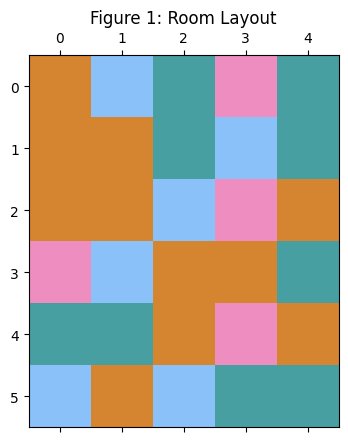

In [4]:
room = np.array(
    [
        [1, 2, 3, 0, 3,],
        [1, 1, 3, 2, 3,],
        [1, 1, 2, 0, 1,],
        [0, 2, 1, 1, 3,],
        [3, 3, 1, 0, 1,],
        [2, 1, 2, 3, 3,],
    ]
)

# Uncomment this for generating data from a bigger room. Will take longer to train.
#
# room = np.array(
#     [
#         [1, 2, 3, 0, 3, 1, 1, 1],
#         [1, 1, 3, 2, 3, 2, 3, 1],
#         [1, 1, 2, 0, 1, 2, 1, 0],
#         [0, 2, 1, 1, 3, 0, 0, 2],
#         [3, 3, 1, 0, 1, 0, 3, 0],
#         [2, 1, 2, 3, 3, 3, 2, 0],
#     ]
# )


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [5]:
# Generate data from the room and train a CSCG. Takes about a minute

n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training   use n_iter=1000 for better training


Average number of clones: 70.0


100%|██████████| 100/100 [00:33<00:00,  2.97it/s, train_bps=0.0261]


In [8]:
# Consolidate learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  1%|          | 1/100 [00:00<00:21,  4.67it/s, train_bps=0.00163]


[0.0016258566, 0.0016258566]

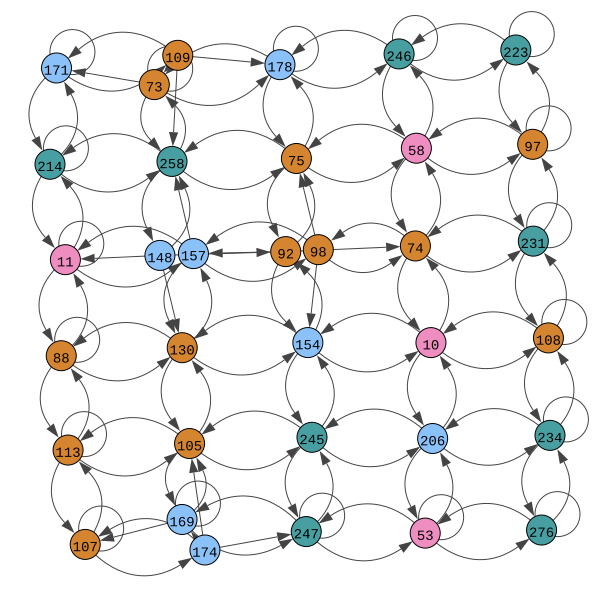

In [9]:
# Visualize the learned, consolidated CSCG for the room.

graph = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph

# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.

In [10]:
# Calculate the forward messages on this CSCG corresponding the original random walk.
# This is used for calculating place field
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.0001)

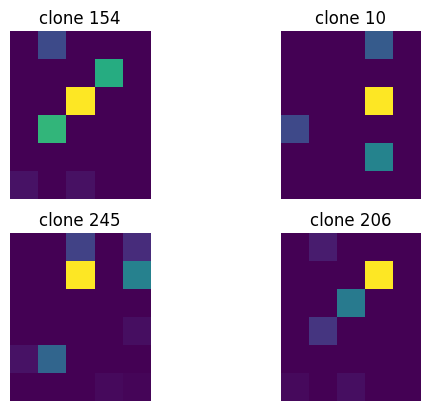

In [11]:
clone_indices = [154, 10, 245, 206]   # This needs to be changed to pick an actual number from the graph
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

# Note that the place field has weak repetitions in locations where the same observations occur.
# Changing the smoothing value in mess_fwd computation will change the strength of these 'side lobes'

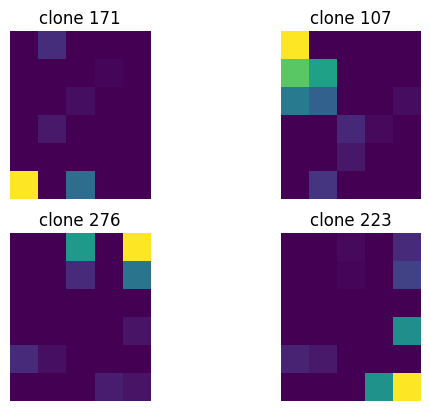

In [12]:
# Place fields in the 4 corners
clone_indices = [171, 107, 276, 223]   # This needs to be changed to pick an actual number from the graph
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")


# Place fields in empty rectangular room

---



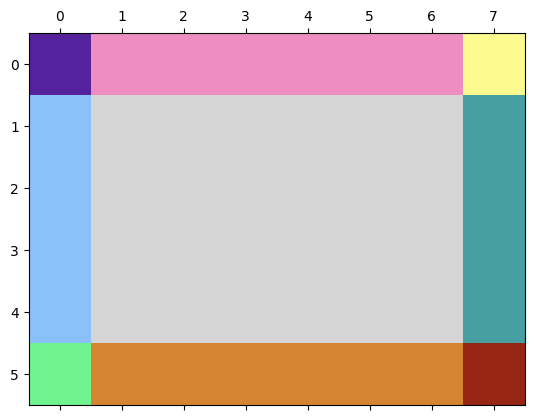

In [13]:
# Create the room layout and visualize
H, W = 6, 8
room = np.zeros((H, W), dtype=np.int64)
room[:] = 0
room[0] = 5
room[-1] = 6
room[:, 0] = 7
room[:, -1] = 8
room[0, 0] = 1
room[0, -1] = 2
room[-1, 0] = 3
room[-1, -1] = 4
cmap = colors.ListedColormap(custom_colors)
plt.matshow(room, cmap=cmap)
plt.savefig("figures/empty_rectangular_room_layout.pdf")

In [14]:
# Generate random walk data from the above room and train a CSCG. Takes about a minute.
a, x, rc = datagen_structured_obs_room(room, length=10000)  # Make length = 50000 for better learning

# Create and train CSCG
n_emissions = room.max() + 1
n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=4)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training  # Make n_iter=1000 for better learning of the model.

Average number of clones: 70.0


100%|██████████| 100/100 [00:51<00:00,  1.94it/s, train_bps=0.108]


In [15]:
# refine learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

 17%|█▋        | 17/100 [00:04<00:21,  3.83it/s, train_bps=0.112]


[0.26075152,
 0.14085497,
 0.13071701,
 0.12842886,
 0.124864124,
 0.117370084,
 0.11456924,
 0.11387909,
 0.11360298,
 0.11349183,
 0.113413855,
 0.113360256,
 0.11327521,
 0.11237647,
 0.1121031,
 0.11208186,
 0.11208009,
 0.11208009]

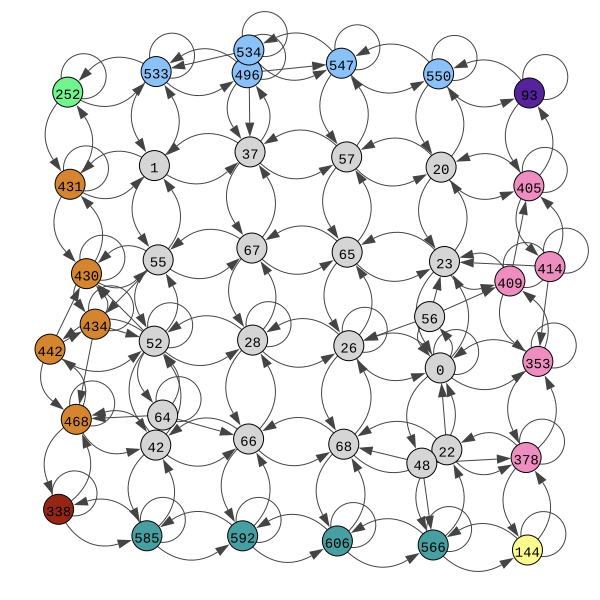

In [16]:
graph = plot_graph(
    chmm, x, a, output_file="figures/empty_rectangular_room_graph.pdf", cmap=cmap, vertex_size=30
)
graph

# CSCG learned an approximate model of the room. Note that the room size is not correct.

In [17]:
# Compute the sequene of neuron activations
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=1e-10)

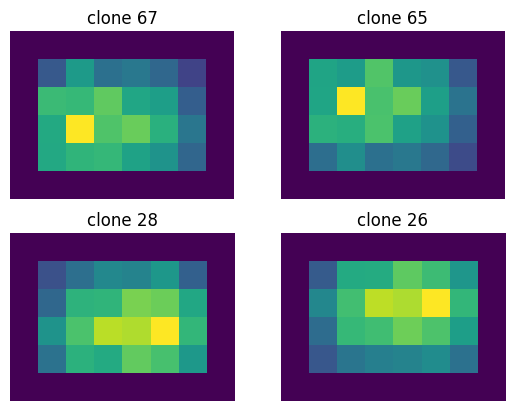

In [18]:
clone_indices = [67, 65, 28, 26]   # These numbers are picked from the graph above
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

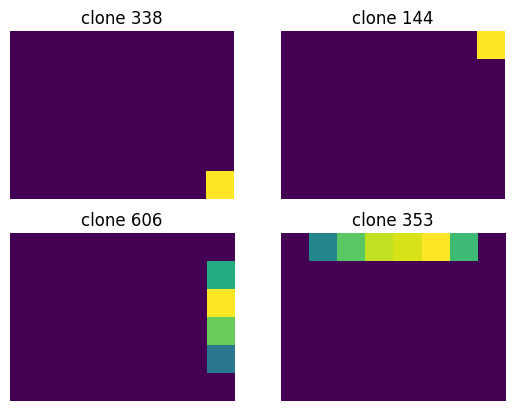

In [19]:
clone_indices = [338, 144, 606, 353]   # Two corner neurons, two edge neurons
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

In [20]:
# Note above that the place fields in the middle are large and more imprecise.
# Place fields along the edges are elongated along the edge.
# And place field in the corner is small and precise.

Average number of clones: 70.0


  2%|▏         | 2/100 [00:03<02:32,  1.56s/it, train_bps=0.000186]


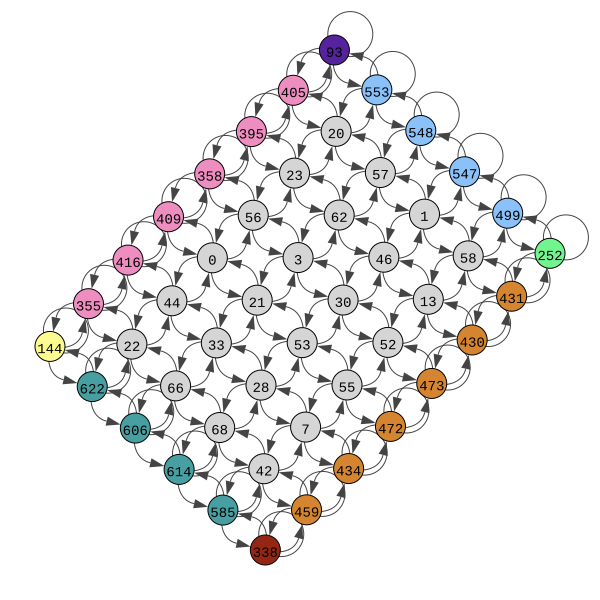

In [21]:
# Generate longer data sequence and run training for more iterations to learn a better model.
# WARNING: This can take about 20 minutes.

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
a, x, rc = datagen_structured_obs_room(room, length=50000)
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=4)  # Initialize the model

progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

graph = plot_graph(
    chmm, x, a, output_file="figures/empty_rectangular_room_graph.pdf", cmap=cmap, vertex_size=30
)
graph

In [22]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=1e-10)

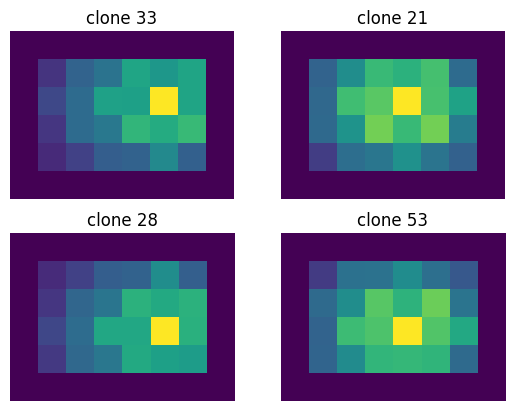

In [23]:
clone_indices = [33, 21, 28, 53]   # 4 neurons in the middle of the room
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

# Note that the neuron fields are more precise with more learning. Also the learned graph represents the room perfectly.

# Transitive learning. From disjoint experience in two overlapping rooms, CSCG learns a coherent unified model.

In [24]:
room1 = np.array(
    [
        [12, 4, 0, 1, 13, 2],
        [7, 3, 12, 11, 0, 10],
        [5, 12, 14, 12, 9, 4],
        [5, 0, 14, 7, 4, 8],
        [4, 10, 7, 2, 13, 1],
        [3, 14, 8, 3, 12, 11],
        [1, 1, 5, 12, 14, 12],
        [5, 9, 3, 0, 14, 7],
    ]
)

room2 = np.array(
    [
        [3, 12, 11, 4, 11, 11],
        [12, 14, 12, 11, 9, 1],
        [0, 14, 7, 2, 4, 9],
        [0, 0, 9, 8, 2, 11],
        [8, 13, 8, 6, 9, 2],
        [0, 5, 4, 13, 2, 14],
        [14, 4, 13, 7, 9, 14],
        [11, 1, 3, 13, 3, 0],
    ]
)

H, W = room1.shape

no_left = [(r, 0) for r in range(H)]
no_right = [(r, W-1) for r in range(H)]
no_up = [(0, c) for c in range(W)]
no_down = [(H-1, c) for c in range(W)]

a1, x1, rc1 = datagen_structured_obs_room(room1, None, None, no_left, no_right, no_up, no_down, length=50000)
a2, x2, rc2 = datagen_structured_obs_room(room2, None, None, no_left, no_right, no_up, no_down, length=50000)

x = np.hstack((0, x1 + 1, 0, x2 + 1))
a = np.hstack((4, a1[:-1], 4, 4, a2))

n_emissions = x.max() + 1

n_clones = 20 * np.ones(n_emissions, int)
n_clones[0] = 1
chmm = CHMM(n_clones=n_clones, pseudocount=2e-2, x=x, a=a, seed=19)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


Average number of clones: 18.8125


 18%|█▊        | 181/1000 [01:56<08:48,  1.55it/s, train_bps=0.0262]


In [25]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
bps = chmm.bps(x, a)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
print("n_states: {} (88 for perfect recovery), bps: {}".format(n_states, bps))


  2%|▏         | 2/100 [00:02<01:44,  1.07s/it, train_bps=0.000102]


n_states: 88 (88 for perfect recovery), bps: [ 8.23362  1.      -0.      ... -0.      -0.      -0.     ]


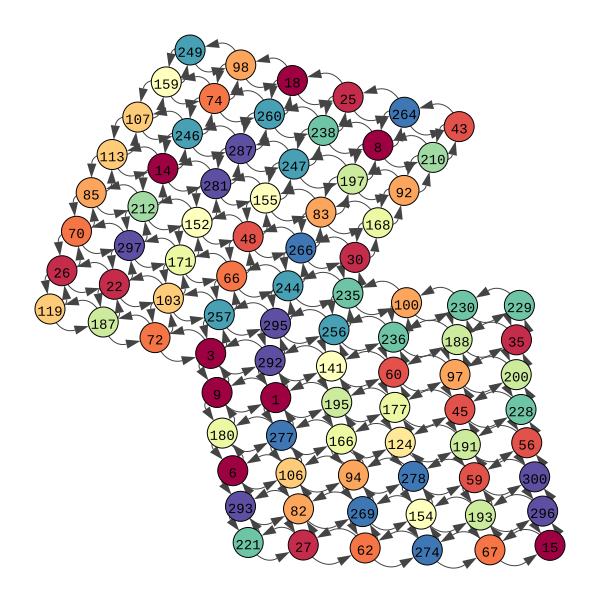

In [26]:
graph = plot_graph(chmm, x, a, output_file="figures/stitched_rooms.pdf", multiple_episodes=True)
graph


In [27]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

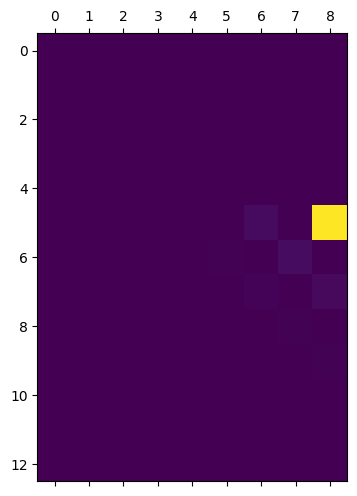

In [28]:
clone = 229
rc = np.vstack(((0, 8), rc1, (0, 8), rc2 + (5, 3)))
pf = place_field(mess_fwd, rc, clone)
pf[0, 8] = 0.0
plt.matshow(pf)
plt.savefig("figures/stitched_rooms_place_field.pdf")

## Three pentagonal cliques

Average number of clones: 5.0


  9%|▊         | 86/1000 [00:04<00:43, 20.81it/s, train_bps=2.06]


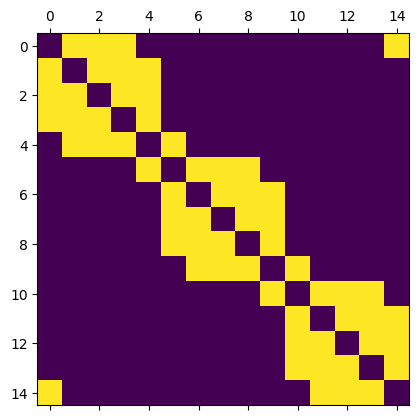

In [29]:
T = np.zeros((15, 15))
# Connect cliques
for i in range(0, 4 + 1):
    for j in range(0, 4 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(5, 9 + 1):
    for j in range(5, 9 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(10, 14 + 1):
    for j in range(10, 14 + 1):
        if i != j:
            T[i, j] = 1.0
# Disconnect in clique connector nodes
T[0, 4] = 0.0
T[4, 0] = 0.0
T[5, 9] = 0.0
T[9, 5] = 0.0
T[10, 14] = 0.0
T[14, 10] = 0.0
# Connect cross clique connector nodes
T[4, 5] = 1.0
T[5, 4] = 1.0
T[9, 10] = 1.0
T[10, 9] = 1.0
T[14, 0] = 1.0
T[0, 14] = 1.0
plt.matshow(T)

# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]

    possible_next_states = np.where(T[prev_state, :])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = (
    np.array([1, 2, 3, 4, 5, 6, 1, 4, 5, 2, 8, 2, 3, 5, 7], dtype=int) - 1
)  # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x), dtype=int)

n_clones = np.ones(8, dtype=np.int64) * 5
chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


In [30]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
n_states


  3%|▎         | 3/100 [00:01<00:48,  2.01it/s, train_bps=1.99]


15

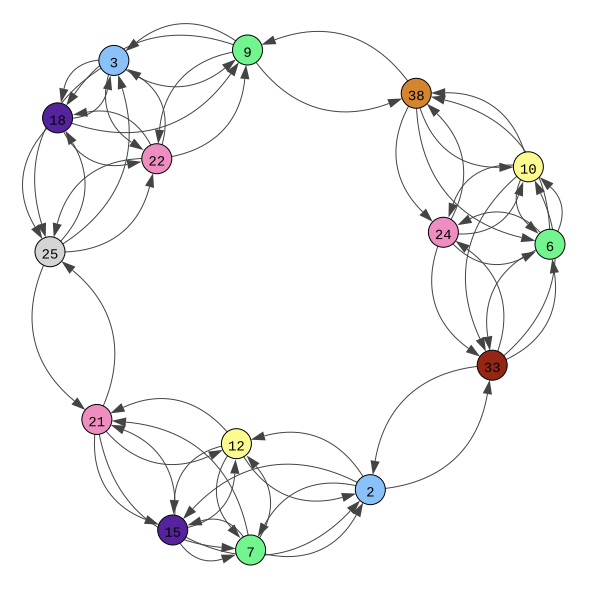

In [31]:
cmap = colors.ListedColormap(custom_colors[[7, 3, 2, 1, 5, 0, 4, 6]])
graph = plot_graph(chmm, x, a, output_file="figures/pentagonal_cliques.pdf", cmap=cmap)
graph
